In [36]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.optimize import linear_sum_assignment


In [37]:
# CITY LAYOUT AND GRAPH FUNCTIONS

def generate_imperfect_grid_adjacency_matrix(num_nodes, skip_prob=0.15, extra_edges=0.15):
    if num_nodes <= 1:
        raise ValueError("Number of nodes must be greater than 1")

    grid_size = int(np.ceil(np.sqrt(num_nodes)))
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(num_nodes):
        if i % grid_size != grid_size - 1 and i + 1 < num_nodes:
            if random.random() > skip_prob:
                adjacency_matrix[i][i + 1] = 1
                adjacency_matrix[i + 1][i] = 1
        if i + grid_size < num_nodes:
            if random.random() > skip_prob:
                adjacency_matrix[i][i + grid_size] = 1
                adjacency_matrix[i + grid_size][i] = 1

    num_extra_edges = int(extra_edges * num_nodes)
    edges_added = 0
    while edges_added < num_extra_edges:
        node1 = random.randint(0, num_nodes - 1)
        node2 = random.randint(0, num_nodes - 1)
        if node1 != node2 and adjacency_matrix[node1][node2] == 0:
            adjacency_matrix[node1][node2] = 1
            adjacency_matrix[node2][node1] = 1
            edges_added += 1

    return adjacency_matrix

def generate_grid_adjacency_matrix(num_nodes):
    if num_nodes <= 1:
        raise ValueError("Number of nodes must be greater than 1")

    grid_size = int(np.ceil(np.sqrt(num_nodes)))  # Define grid size
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(num_nodes):
        # Add self-loops
        adjacency_matrix[i][i] = 1
        
        # Connect to the right neighbor if it exists
        if (i + 1) % grid_size != 0 and i + 1 < num_nodes:
            adjacency_matrix[i][i + 1] = 1
            adjacency_matrix[i + 1][i] = 1
        
        # Connect to the bottom neighbor if it exists
        if i + grid_size < num_nodes:
            adjacency_matrix[i][i + grid_size] = 1
            adjacency_matrix[i + grid_size][i] = 1

    return adjacency_matrix


def visualize_graph(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    pos = {i: (i % int(np.ceil(np.sqrt(len(adj_matrix)))), int(np.ceil(np.sqrt(len(adj_matrix)))) - (i // int(np.ceil(np.sqrt(len(adj_matrix)))))) for i in range(len(adj_matrix))}
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Imperfect Grid-Like City Graph")
    plt.show()

def generate_fully_connected_adjacency_matrix(num_nodes, skip_prob=0.15, extra_edges=0.15):
    while True:
        adj_matrix = generate_imperfect_grid_adjacency_matrix(num_nodes, skip_prob, extra_edges)
        
        adj_matrix2 = generate_grid_adjacency_matrix(num_nodes)
        visualize_graph(adj_matrix)
        visualize_graph(adj_matrix2)
        
        G = nx.from_numpy_array(adj_matrix)
        if nx.is_connected(G):
            return adj_matrix



In [38]:
# TRAFFIC AND TIME SERIES SIMULATION

def generate_seasonal_demand(length, num_nodes, mean, std_dev, amplitude_range, period_range, num_periods_range):
    seasonal_patterns = [generate_complex_seasonal_pattern(length, amplitude_range, period_range, num_periods_range) for _ in range(num_nodes)]
    demand = np.zeros((length, num_nodes), dtype=int)

    for t in range(length):
        for i in range(num_nodes):
            base_demand = np.random.normal(mean * seasonal_patterns[i][t], std_dev)
            demand[t, i] = max(0, int(base_demand))

    return demand

def generate_complex_seasonal_pattern(length, amplitude_range, period_range, num_periods_range):
    t = np.arange(length)
    seasonal_pattern = np.zeros(length)
    num_periods = np.random.randint(*num_periods_range)
    period_length = length // num_periods

    for _ in range(num_periods):
        frequency = np.random.uniform(0.5, 2.0)
        amplitude = np.random.uniform(*amplitude_range)
        phase = np.random.uniform(0, 2 * np.pi)
        start = np.random.randint(0, length - period_length)
        end = start + period_length
        seasonal_pattern[start:end] += amplitude * np.sin(frequency * 2 * np.pi * t[start:end] / period_length + phase)

    seasonal_pattern += np.random.normal(scale=0.1, size=length)
    return np.maximum(1, seasonal_pattern)

def generate_random_dropoffs(num_nodes, demand):
    dropoffs = {}
    for t in range(demand.shape[0]):
        for node in range(demand.shape[1]):
            num_pickups = demand[t, node]
            dropoff_list = [random.randint(0, num_nodes - 1) for _ in range(num_pickups)]
            dropoffs[(t, node)] = dropoff_list
    return dropoffs    

def generate_driver_series(num_nodes, length, mean, std_dev):
    driver_counts = np.random.normal(loc=mean, scale=std_dev, size=(length, num_nodes))
    driver_counts = np.clip(driver_counts, 0, None)  # Ensure non-negative counts
    return np.round(driver_counts).astype(int)

In [39]:
# UTILITY FUNCTIONS 

def visualize_pickup_series(demand):
    length, num_nodes = demand.shape
    time_steps = np.arange(length)
    
    plt.figure(figsize=(6, 4))
    for i in range(num_nodes):
        plt.plot(time_steps, demand[:, i], label=f'Node {i}')
    
    plt.xlabel('Time Step')
    plt.ylabel('Pickups')
    plt.title('Taxi Pickup Time Series')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))
    plt.grid(True)
    plt.show()

def visualize_node_influence(demand):
    correlation_matrix = np.corrcoef(demand.T)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=True, yticklabels=True)
    plt.title('Correlation Heatmap of Taxi Pickup Time Series')
    plt.xlabel('Node')
    plt.ylabel('Node')
    plt.show()

def calculate_distance(graph, start, end):
    path_length = nx.shortest_path_length(graph, source=start, target=end, weight='weight', method='dijkstra')
    return path_length

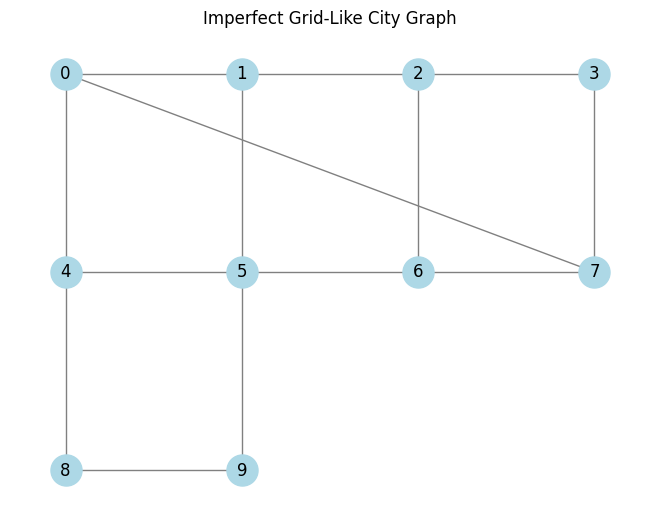

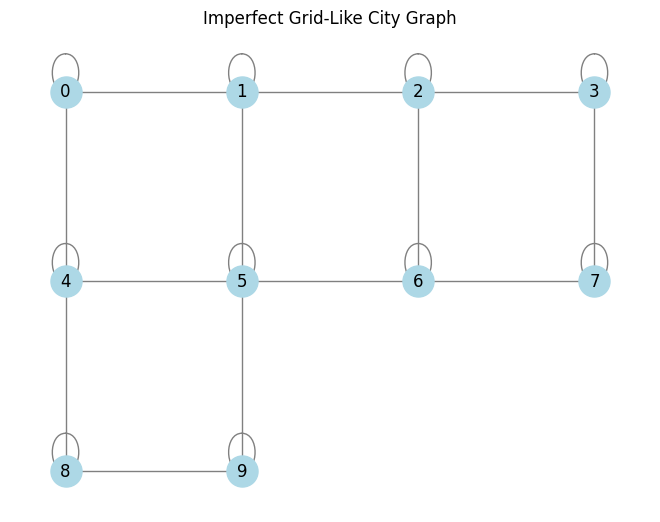

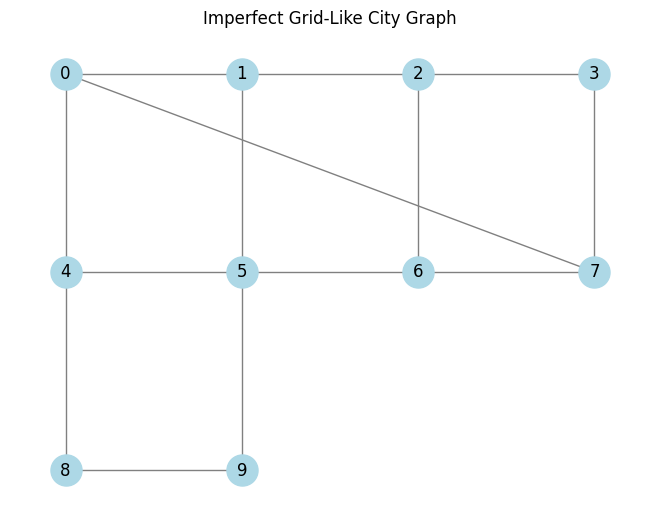

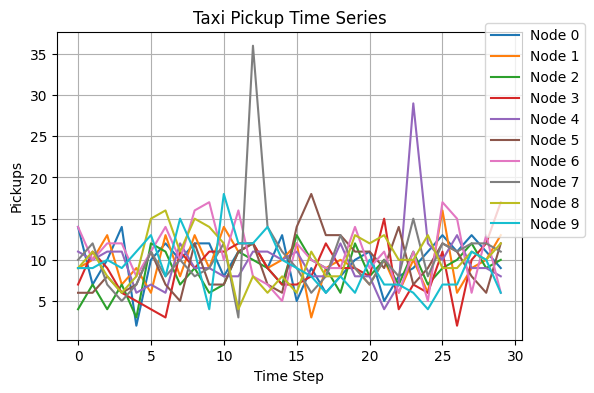

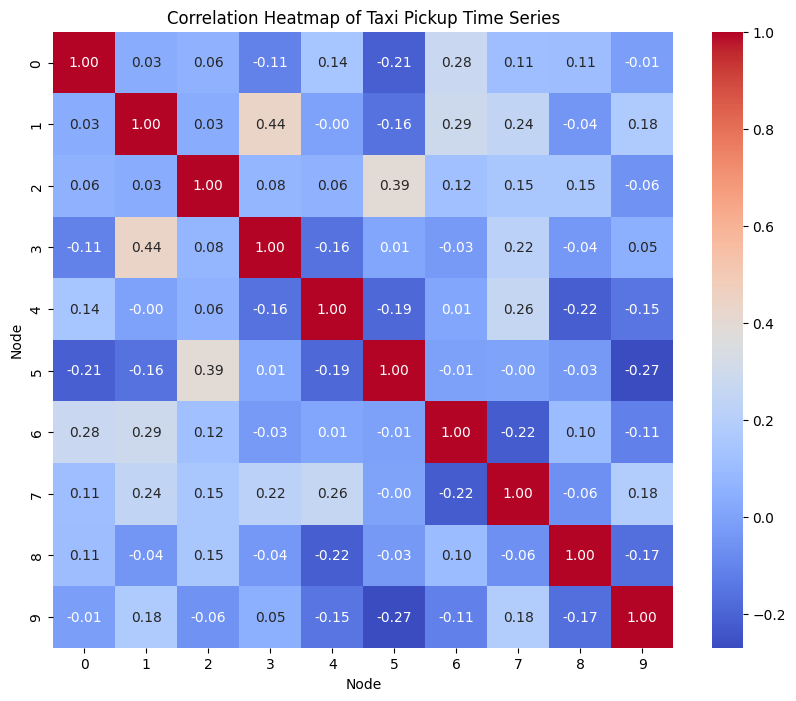

In [40]:
# GRAPH GENERATION

num_nodes = 10  
skip_prob = 0.15  # Probability of skipping an edge 
extra_edges = 0.15  # Probability of additional edge


adj_matrix = generate_fully_connected_adjacency_matrix(num_nodes, skip_prob, extra_edges)


# DEMAND SIMULATION

length = 30  # Duration 
mean = 10  # Mean demand per node 
std_dev = 3  # Demand stdev
amplitude_range = (0.5, 1.5)  # Amplitude demand range
period_range = (10, 50)  # Range of demand periods
num_periods_range = (3, 10)  # Range for number of periods within length

# TIME SERIES GENERATION

pickup_series = generate_seasonal_demand(length, num_nodes, mean, std_dev, amplitude_range, period_range, num_periods_range)
dropoffs = generate_random_dropoffs(num_nodes, pickup_series)

# DRIVER SIMULATION

driver_mean = 10 
driver_std_dev = 2 
drivers_series = generate_driver_series(num_nodes, length, driver_mean, driver_std_dev)

def visualize(): 
    # Visualize pickup patterns
    visualize_graph(adj_matrix)
    visualize_pickup_series(pickup_series)
    visualize_node_influence(pickup_series)

visualize()



In [41]:
# PRINTING SAMPLES

print("Sample pickup series for Node 0:", pickup_series[:, 0])
print("Sample driver series for Node 0:", drivers_series[:, 0])
print("Dropoffs for first time step at Node 0:", dropoffs.get((0, 0), "No pickups"))

Sample pickup series for Node 0: [14  7 10 14  2 10 12 10 12 12  8 11 12  9 13  5  9  6  8 10 11  5  8  9
 11 13 11 13 11  9]
Sample driver series for Node 0: [12  8  8 11  9 12 12  8 11  9  7 10  9 11 12  8  8  7 12  8 10 11 11 11
 13  7 11  7 10  8]
Dropoffs for first time step at Node 0: [3, 9, 8, 1, 5, 6, 6, 4, 6, 8, 1, 0, 7, 9]


In [42]:
# BASIC MATCHING FUNCTION, USES STATIC LINEAR SUM ASSIGNMENT

def matching_function(pickup_series, dropoffs, adj_matrix, driver_series, num_nodes):
    G = nx.from_numpy_array(adj_matrix)  # Create a graph from the adjacency matrix
    results = []
    unmatched_drivers = 0
    unmatched_riders = 0
    total_drivers = 0  # Total drivers processed
    total_riders = 0   # Total riders processed
    total_matched_riders = 0  # Total matched riders

    for t in range(len(driver_series)):
        drivers = [i for i, count in enumerate(driver_series[t]) for _ in range(count)]  # Create a list of drivers for this time step
        pickup_nodes = [node for node, pickups in enumerate(pickup_series[t]) for _ in range(pickups)]
        dropoff_nodes = [dropoff for node, pickups in enumerate(pickup_series[t]) for dropoff in dropoffs.get((t, node), [])]

        num_drivers = len(drivers)
        num_rides = len(pickup_nodes)

        total_drivers += num_drivers  # Add current period's drivers to total
        total_riders += num_rides  # Add current period's riders to total

        if num_rides == 0:  # If no rides to assign, skip to the next period
            continue

        cost_matrix = np.zeros((num_drivers, num_rides))
        for i in range(num_drivers):
            for j in range(num_rides):
                driver_to_pickup = calculate_distance(G, drivers[i], pickup_nodes[j])
                pickup_to_dropoff = calculate_distance(G, pickup_nodes[j], dropoff_nodes[j])
                cost_matrix[i, j] = driver_to_pickup + pickup_to_dropoff

        # Find the optimal assignment of drivers to rides
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        results.extend([(drivers[row], pickup_nodes[col], dropoff_nodes[col]) for row, col in zip(row_ind, col_ind)])

        unmatched_drivers += num_drivers - len(row_ind)
        unmatched_riders += num_rides - len(col_ind)
        total_matched_riders += len(col_ind)  # Count the matched riders

    return results, unmatched_drivers, unmatched_riders

In [43]:
# Function to match drivers with pickups and dropoffs, minimizing total travel distance
results, unmatched_drivers, unmatched_riders = matching_function(pickup_series, dropoffs, adj_matrix, drivers_series, num_nodes)

# Print out the results of the matching process
print("Total Drivers:", np.sum(drivers_series))
print("Unmatched Drivers:", unmatched_drivers)

print("Total Riders:", np.sum(pickup_series))
print("Unmatched Riders:", unmatched_riders)


Total Drivers: 2972
Unmatched Drivers: 188
Total Riders: 2907
Unmatched Riders: 123
